# PCLab#3 - Group 1 - Johannes, Petter, and Oskar

Big picture context
- You’ve just been hired by a sophisticated hedge-fund
- The hedge-fund manager is interested in Twitter’s predictive power
- He asks you to perform sentiment analysis on a sample of recent financial tweets...
- ... and to build a firm-level measure of media attention: that may be a great factor idea !

Packages you may need
- Among others: wordcloud, nltk.stem, nltk.corpus, nltk.tokenize, gensim, tensorflow, string.punctuation, sklearn, etc.

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import warnings

## Task #1: Basic manipulation and descriptive statistics
- Import the Data_PCLab3_Twitter_Stock_Sentiment.csv data and describe the sample (data available on BBoard)
- How many tweets, how many words per tweets, distribution of number of words per tweets, average sentiment, etc.

In [2]:
tweets = pd.read_csv('./data/Data_PCLab3_Twitter_Stock_Sentiment.csv')
stocks = pd.read_csv('./data/Data_PCLab1_Stock.csv',  index_col=0)

In [3]:
# Total number of tweets
total_tweets = len(tweets)
# Number of words per tweet
tweets['word_count'] = tweets['Text'].apply(lambda x: len(x.split()))
# Descriptive statistics for the number of words per tweet
word_stats = tweets['word_count'].describe()
# Average sentiment
average_sentiment = tweets['Sentiment'].mean()
# Output description
print(f"Total number of tweets: {total_tweets}\n")
print(f"Word count statistics per tweet:\n{word_stats}")
print(f"\nAverage sentiment: {average_sentiment}")

Total number of tweets: 5791

Word count statistics per tweet:
count    5791.000000
mean       14.008807
std         6.595945
min         2.000000
25%         9.000000
50%        14.000000
75%        19.000000
max        32.000000
Name: word_count, dtype: float64

Average sentiment: 0.6363322396822656


**Chart to visualize the distribution of words per tweet**

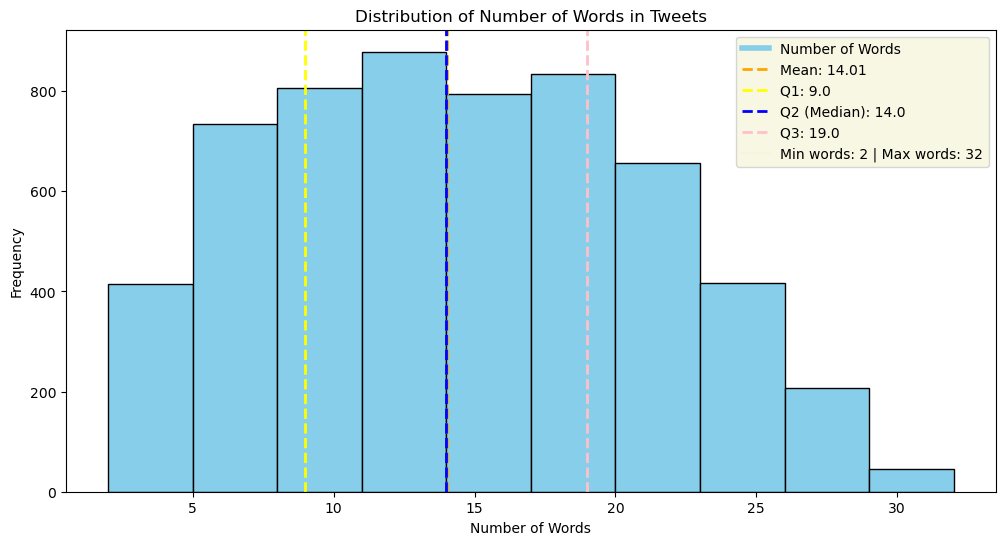

In [4]:
words_per_tweet = tweets['Text'].apply(lambda x: len(x.split()))

# Calculate descriptive statistics
min_words = words_per_tweet.min()
max_words = words_per_tweet.max()
mean_words = words_per_tweet.mean()
quartiles = np.percentile(words_per_tweet, [25, 50, 75])

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(words_per_tweet, bins=10, color='skyblue', edgecolor='black')

# Add  lines for the descriptive statistics
plt.axvline(mean_words, color='orange', lw=2, linestyle='--', label='Mean')
plt.axvline(quartiles[0], color='yellow', lw=2, linestyle='--', label='Q1')
plt.axvline(quartiles[1], color='blue', lw=2, linestyle='--', label='Q2 (Median)')
plt.axvline(quartiles[2], color='pink', lw=2, linestyle='--', label='Q3')

# Add title and label axis
plt.title('Distribution of Number of Words in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Add a text box for annotations
# Define legend elements
legend_elements = [
    plt.Line2D([0], [0], color='skyblue', lw=4, label='Number of Words'),
    plt.Line2D([0], [0], color='orange', linestyle='--', lw=2, label=f'Mean: {mean_words:.2f}'),
    plt.Line2D([0], [0], color='yellow', linestyle='--', lw=2, label=f'Q1: {quartiles[0]}'),
    plt.Line2D([0], [0], color='blue', linestyle='--', lw=2, label=f'Q2 (Median): {quartiles[1]}'),
    plt.Line2D([0], [0], color='pink', linestyle='--', lw=2, label=f'Q3: {quartiles[2]}'),
    plt.Line2D([0], [0], color='beige', label=f'Min words: {min_words} | Max words: {max_words}')
]

# Add the legend
plt.legend(facecolor='beige', handles=legend_elements, loc='best')

# Plot the chart
plt.show()

### Describe the dataset
The dataset consists of 5791 tweets along with their corresponding sentiment values.

The dataset is structured with two columns:
- Text: This column contains the actual text content of each tweet.
- Sentiment: This column represents the sentiment associated with each tweet, with '1' indicating positive sentiment and '0' indicating negative sentiment.

##### Descriptive Statistics
- Average words per tweet: 14.01 words
- Average sentiment: 0.6363
- Minimum words per tweet: 2
- Maximum words per tweet: 32
- Distribution of words per tweet: Most tweets are between 5 and 23 tweets.Tweets rarely are longer than 25 words.

## Task #2 : Cleaning and visualization
- Usual cleaning steps: remove punctuation, stopwords, short words, etc.
- Try your cleaning on this sentence: $I love AI & Machine learning applied to Finance...!! ;)
- Plot a word cloud for text with positive and negative sentiment separately
- What is the number of unique words ?

In [5]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download stopwords and punkt tokenizer if needed
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

**Clean the text**

In [14]:

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Expanded tickers dictionary with variations for each stock
tickers_dict = {
    "AAPL": ["AAPL", "AAP", "Apple"],
    "BA": ["BA", "Boeing"],
    "T": ["T", "AT&T"],
    "MGM": ["MGM"],
    "AMZN": ["AMZN", "Amazon", "Bezoz", "Jeff"],
    "IBM": ["IBM"],
    "TSLA": ["TSLA", "Tesla", "Elon", "Musk"],
    "GOOG": ["GOOG", "Google"],
    "sp500": ["sp500", "S&P500"]
}


# Function to clean text and detect stock tickers
def clean_text(text, tickers_dict):
    # Remove punctuation, but keep decimal points between numbers
    text = re.sub(r'(?<!\d)[.,;:!?](?!\d)', '', text)
    
    # Tokenize the text
    words = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize (keeping short but important words like "i")
    clean_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words or len(word) == 1]
    
    # Join the clean words into a single string
    cleaned_text = " ".join(clean_words)
    
    # Check if any ticker symbols or variations are present in the text
    tickers_in_text = {}
    for ticker, variations in tickers_dict.items():
        tickers_in_text[ticker] = any(re.search(r'\b' + re.escape(variation.lower()) + r'\b', cleaned_text) for variation in variations)
        
        # Remove the ticker variations from the cleaned text
        for variation in variations:
            cleaned_text = re.sub(r'\b' + re.escape(variation.lower()) + r'\b', '', cleaned_text)

    # Convert True/False to 1/0
    tickers_in_text = {k: 1 if v else 0 for k, v in tickers_in_text.items()}
        
    return cleaned_text, tickers_in_text

# Apply the cleaning function to all tweets and store the ticker presence as new boolean columns
def process_tweets(row, tickers_dict):
    cleaned_text, tickers_in_text = clean_text(row['Text'], tickers_dict)
    # Add cleaned text back to the row
    row['cleaned_text'] = cleaned_text
    # Add ticker presence as new columns
    for ticker, present in tickers_in_text.items():
        row[f'{ticker}_present'] = present
    return row

# Apply to tweets dataframe
tweets = tweets.apply(lambda row: process_tweets(row, tickers_dict), axis=1)

# Display the updated tweets dataframe with the new ticker columns
tweets.head(100)

,Text,Sentiment,word_count,cleaned_text,AAPL_present,BA_present,T_present,MGM_present,AMZN_present,IBM_present,TSLA_present,GOOG_present,sp500_present
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,20,kicker watchlist xide tit soq pnk cpw bpz aj t...,0,0,0,0,0,0,0,0,0
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,16,user movie 55 % return fea/geed indicator 15 ...,1,0,0,0,0,0,0,0,0
2,user I'd be afraid to short AMZN - they are lo...,1,18,user i 'd afraid short - looking like a near-...,0,0,0,0,1,0,0,0,0
3,MNTA Over 12.00,1,3,mnta 12.00,0,0,0,0,0,0,0,0,0
4,OI Over 21.37,1,3,oi 21.37,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NG nhod - check the weekly - target previous l...,1,12,ng nhod - check weekly - target previous low 2...,0,0,0,0,0,0,0,0,0
96,NG nhod - what do you see? check the weekly - ...,1,16,ng nhod - see check weekly - target previous l...,0,0,0,0,0,0,0,0,0
97,AIG American International Group Option Trader...,0,14,aig american international group option trader...,0,0,0,0,0,0,0,0,0
98,P out balance +.32,1,4,p balance +.32,0,0,0,0,0,0,0,0,0


In [7]:
tweets.describe()

,Sentiment,word_count,AAPL_present,BA_present,T_present,MGM_present,AMZN_present,IBM_present,TSLA_present,GOOG_present,sp500_present
count,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.0
mean,0.636332,14.008807,0.159731,0.002072,0.037990,0.002072,0.020204,0.003626,0.000691,0.034709,0.0
std,0.481096,6.595945,0.366388,0.045478,0.191189,0.045478,0.140709,0.060115,0.026275,0.183058,0.0
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [15]:
# Example usage of the function with a test sentence
sample_sentence = "$I love AI & Machine learning applied to Finance...!! ;) Musk"
cleaned_sentence, tickers_present = clean_text(sample_sentence, tickers_dict)

print("Cleaned Sentence: ", cleaned_sentence)
print("Tickers Present: ", tickers_present)

Cleaned Sentence:  $ i love ai & machine learning applied finance ) 
Tickers Present:  {'AAPL': 0, 'BA': 0, 'T': 0, 'MGM': 0, 'AMZN': 0, 'IBM': 0, 'TSLA': 1, 'GOOG': 0, 'sp500': 0}


**Wordcloud**

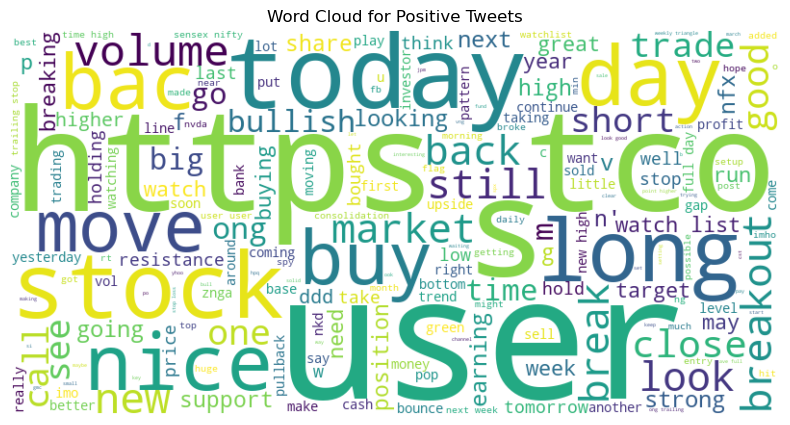

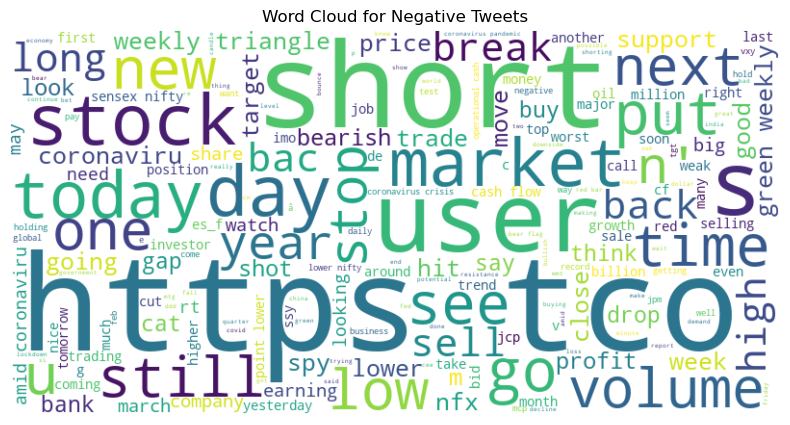

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Split data by sentiment
positive_tweets = " ".join(tweets[tweets['Sentiment'] == 1]['cleaned_text'])
negative_tweets = " ".join(tweets[tweets['Sentiment'] == 0]['cleaned_text'])

# create wordcloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
plot_wordcloud(positive_tweets, 'Word Cloud for Positive Tweets')
plot_wordcloud(negative_tweets, 'Word Cloud for Negative Tweets')

**Number of unique words**

In [17]:
# Join all cleaned tweets into one large string
all_words = " ".join(tweets['cleaned_text'])
all_cleaned_words=all_words.translate(str.maketrans('', '', string.punctuation))
# Tokenize the words
unique_words = set(all_cleaned_words.split())
# Number of unique words
num_unique_words = len(unique_words)
print(f"Number of unique words: {num_unique_words}")

Number of unique words: 10865


**Comment on results:**
Before excluding the tickers, ticker names such as AAP and GOOG were among the most important words for both positive and negative sentiment tweets. This is likely a direct result of them both being big and liquid firms. However, a stock being mentioned should not be important by itself as we are only looking at the market sentiment. We removed the tickers and ran the models below again, which yielded better results than previously. If we instead were interested in sentiment for particular stocks, including the tickers would be smart.

Furthermore, excluding numbers is not the best way to gain insight on sentiment. Consider this tweet: "AAPL target: 100". If the current price is 50, this is a positive sentiment, but if the price is 200, this is a negative sentiment. Thus, incorporating numbers may yield good results. However, this may lead to other problems due to the significant increase in complexity.

## Task #3 : Sentiment analysis
If any of those steps are not crystal clear, please tell me now (or shoot me an email soon after the class)
- More usual steps: Tokenizing the text and padding
    - Tokenize: vectorize text corpus, transform text into numbers
    - Padding: make all sentences the same lenght (fill with 0 short sentences)
- Split the sample in a train / test dataset (test = 10% of the total sample)
- Train model of your choice (RNN, LTSM, etc.) to predict the sentiment (1 or 0) on the test sample (you could use embedding layer to reduce the dimension of the problem)
- Plot the confusion matrix and compute the accuracy score (e.g., with sklearn function accuracy)

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

**Tokenization and Padding**

In [19]:
# Set the maximum number of words to consider and the max tweet length
MAX_WORDS = num_unique_words  # Use all the words in the vocabulary
MAX_SEQUENCE_LENGTH = words_per_tweet.max()  # Pad all sentences to the maximum lenght of the tweets. 

# Tokenize the text corpus
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(tweets['cleaned_text'])  # Fit tokenizer on cleaned text

# Convert text to sequences of numbers
sequences = tokenizer.texts_to_sequences(tweets['cleaned_text'])

# Pad sequences to make all sentences the same length
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# The labels (sentiment)
y = tweets['Sentiment'].values

**Train-Test Split**

In [20]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### Training models of our choice
These are the models we trained, tested and compared:
- Logistic regression
- RNN
- LSTM
- XGBoost

**Logistic regression**

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def train_logistic_regression(X_train, y_train):
    # Define parameter grid for tuning
    param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear']}
    
    # Initialize logistic regression model
    log_reg = LogisticRegression(random_state=42)
    
    # Grid search for the best parameters
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    return best_model

**RNN**

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

def train_rnn_model(X_train, y_train, max_words=MAX_WORDS, embedding_dim=50):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)
    
    return model

**LSTM**

In [23]:
from tensorflow.keras.layers import LSTM

def train_lstm_model(X_train, y_train, max_words=MAX_WORDS, embedding_dim=50):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)
    
    return model

**XGBoost**

In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

def train_xgboost(X_train, y_train):
    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    # Define parameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    
    # Grid search for the best parameters
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    return best_model

**Use the twitter data to train models**

In [25]:
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Example of using the train data
log_reg_model = train_logistic_regression(X_train, y_train)

rnn_model = train_rnn_model(X_train, y_train)

lstm_model = train_lstm_model(X_train, y_train)

xgb_model = train_xgboost(X_train, y_train)

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6566 - loss: 0.6312 - val_accuracy: 0.7490 - val_loss: 0.5353
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8654 - loss: 0.3347 - val_accuracy: 0.6992 - val_loss: 0.6285
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9493 - loss: 0.1531 - val_accuracy: 0.6954 - val_loss: 0.7810
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9828 - loss: 0.0580 - val_accuracy: 0.7107 - val_loss: 0.8075
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9911 - loss: 0.0280 - val_accuracy: 0.7203 - val_loss: 0.9271
Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6388 - loss: 0.6593 - val_accuracy: 0.7261 - val_loss: 0.5760
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7855 - loss: 0.5211 - val_accuracy: 0.7356 - val_loss: 0.5874
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8295 - loss: 0.4513 - val_accuracy: 0.

**Comparing the models**

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, X_test, y_test, model_name):
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # If using Keras models, convert predictions to binary values (0 or 1)
    if isinstance(model, Sequential):
        y_pred = (y_pred > 0.5).astype(int).reshape(-1)
    
    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Confusion Matrix for {model_name} (accuracy {accuracy:.4f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return

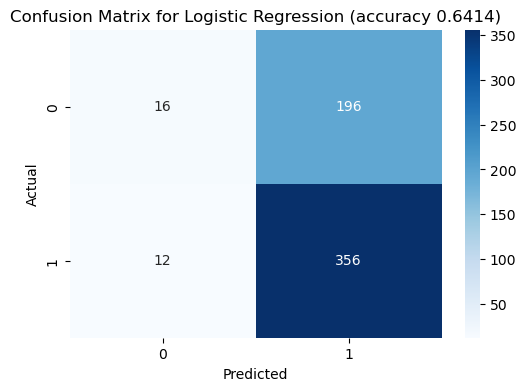

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


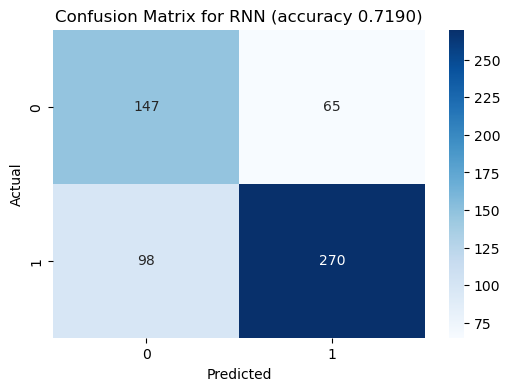

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


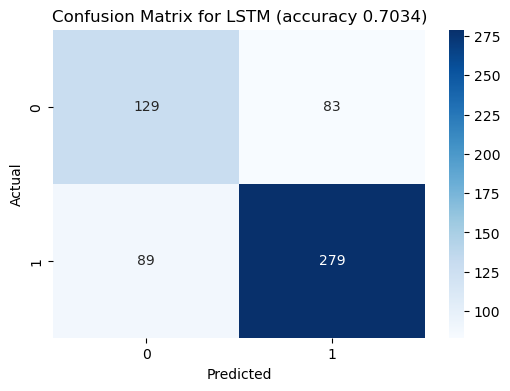

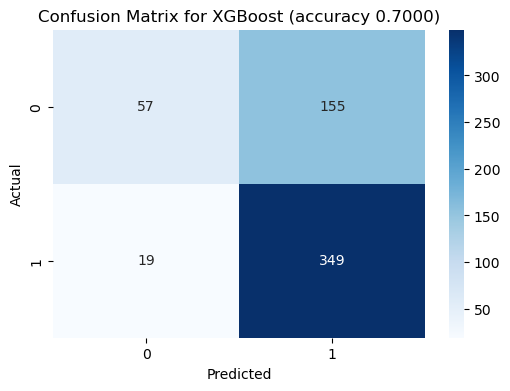

In [27]:
evaluate_model(log_reg_model, X_test, y_test, "Logistic Regression")

evaluate_model(rnn_model, X_test, y_test, "RNN")

evaluate_model(lstm_model, X_test, y_test, "LSTM")

evaluate_model(xgb_model, X_test, y_test, "XGBoost")

**Comment on results of the models**

The LSTM yielded by far the best results. Therefore, we assume this model is the best predictor going forward.

**NOTE:** Before removing the tickers, all models scored between 0.63 and 0.70 on the accuracy. Removing the tickers therefore seem to improve the ML models. Removing more words like 'https' and 'user' may yield even better results and should be tested!


## Task #4 : Sentment analysis - Optional
- Use transformers (BERT from Huggingface) to perform another sentiment analysis and compare to the sentiment value in the data
    - Use pipeline: from transformers import pipeline
    - Use the already created library: text-classification or sentiment-analysis
- What is the performance of the algorithm on financial tweets ? I.e., how does BERT classifies the Tweets compared to the original classification you have ?
- Hint: check the Huggingface website
- To go further: check FinBERT

In [28]:
from transformers import pipeline
from sklearn.metrics import classification_report

**BERT**

In [29]:
sentiment_pipeline = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')

**Applying BERT sentiment analysis to each tweet**

In [30]:
# Applying BERT sentiment analysis to each tweet

def get_bert_sentiment(tweet):
    result = sentiment_pipeline(tweet[:512])  # Truncate tweet to 512 tokens to avoid overflow
    label = result[0]['label']
    if label == 'POSITIVE':
        return 1
    elif label == 'NEGATIVE':
        return 0
    else:
        return 2  # NEUTRAL

# Apply BERT sentiment analysis to each tweet and store the result
tweets['BERT_Sentiment'] = tweets['Text'].apply(get_bert_sentiment)

**Comparing BERT sentiment with the original sentiment labels**

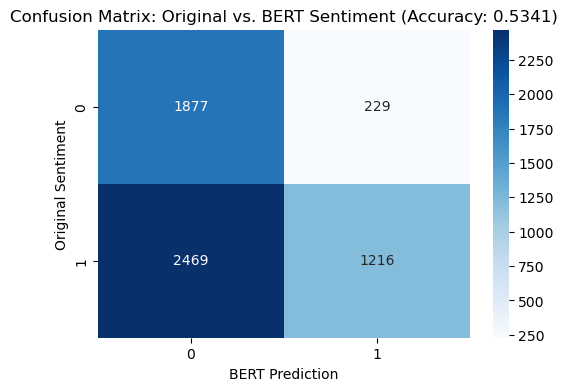

In [31]:
# Comparing BERT sentiment with the original sentiment labels
# print(tweets[['Text', 'Sentiment', 'BERT_Sentiment']])

# Calculate accuracy
accuracy = accuracy_score(tweets['Sentiment'], tweets['BERT_Sentiment'])

# Confusion matrix
cm = confusion_matrix(tweets['Sentiment'], tweets['BERT_Sentiment'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title(f"Confusion Matrix: Original vs. BERT Sentiment (Accuracy: {accuracy:.4f})")
plt.xlabel("BERT Prediction")
plt.ylabel("Original Sentiment")
plt.show()

# Detailed classification report
# print("Classification Report:\n", classification_report(tweets['Sentiment'], tweets['BERT_Sentiment']))

**FinBERT**

In [32]:
# To use FinBERT for financial sentiment analysis, use the following:
finbert_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Apply FinBERT sentiment analysis
def get_finbert_sentiment(tweet):
    result = finbert_pipeline(tweet[:512])  # Truncate tweet to 512 tokens
    label = result[0]['label']
    if label == 'positive':
        return 1
    elif label == 'negative':
        return 0
    else:
        return 2  # Neutral (if FinBERT provides neutral sentiment)
    
# Use FinBERT for sentiment analysis on each tweet
tweets['FinBERT_Sentiment'] = tweets['Text'].apply(get_finbert_sentiment)

# Compare with original sentiments
# print(tweets[['Text', 'Sentiment', 'FinBERT_Sentiment']])

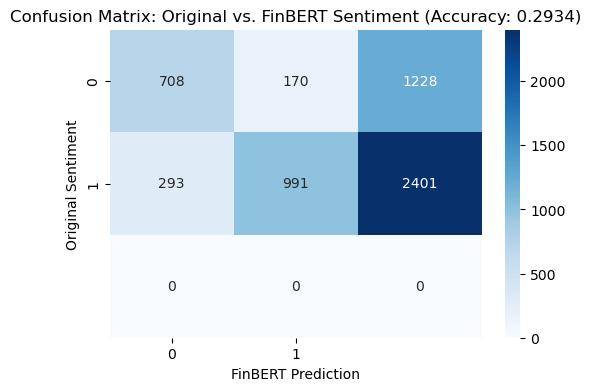

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.34      0.46      2106
           1       0.85      0.27      0.41      3685
           2       0.00      0.00      0.00         0

    accuracy                           0.29      5791
   macro avg       0.52      0.20      0.29      5791
weighted avg       0.80      0.29      0.43      5791



In [33]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Calculate accuracy
accuracy = accuracy_score(tweets['Sentiment'], tweets['FinBERT_Sentiment'])

# Confusion matrix
cm = confusion_matrix(tweets['Sentiment'], tweets['FinBERT_Sentiment'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title(f"Confusion Matrix: Original vs. FinBERT Sentiment (Accuracy: {accuracy:.4f})")
plt.xlabel("FinBERT Prediction")
plt.ylabel("Original Sentiment")
plt.show()

# Detailed classification report
print("Classification Report:\n", classification_report(tweets['Sentiment'], tweets['FinBERT_Sentiment']))

## Task #5 : Measuring media attention
- Use the list of tickers gathered during last PC Lab (see the web-scrapping part) to compute the number of tweets about each stock
    - e.g., AAPL: 36 tweets, 12 negative, 24 positive
- Rank the stocks by their amount of total media attention, positive and negative media attention
- Optional: Using the stock prices data on our 8 stocks (or more from the web-scrapping task), do you see a correlation between media attention and excess return ?
- If yes, could Twitter attention is likely to be a good factor ?

**Collect Tickers**

In [34]:
# Load S&P 500 company list from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace '.' with '-' in symbols (needed for Yahoo Finance compatibility)
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# Create a list of unique symbols
ticker_list = sp500['Symbol'].unique().tolist()

# Replace AAPL by AAP, as AAP is the ticker used for Apple in the twitter data
ticker_list = ['AAP' if ticker == 'AAPL' else ticker for ticker in ticker_list]

**Create a overview of each ticker and there twitter-"stats"**

In [35]:
# initiate a dataframe with tickers as index and columns for mentions and positive sentiment tweets
company_df = pd.DataFrame(index=ticker_list, columns=['mentions', 'positive', 'negative',
                                                      'bert_positive', 'bert_negative',
                                                      'finbert_positive', 'finbert_negative'])

# fill initial values as zero
company_df['mentions'] = 0
company_df['positive'] = 0
company_df['negative'] = 0
company_df['bert_positive'] = 0
company_df['bert_negative'] = 0
company_df['finbert_positive'] = 0
company_df['finbert_negative'] = 0


for i, row in tweets.iterrows():
    for ticker in ticker_list:        
        if ticker in row['Text'].split():
            company_df.loc[ticker, 'mentions'] += 1

            if row['Sentiment'] == 1:
                company_df.loc[ticker, 'positive'] += 1
            else:
                company_df.loc[ticker, 'negative'] += 1

            if row['BERT_Sentiment'] == 1:
                company_df.loc[ticker, 'bert_positive'] += 1
            else:
                company_df.loc[ticker, 'bert_negative'] += 1

            if row['FinBERT_Sentiment'] == 1:
                company_df.loc[ticker, 'finbert_positive'] += 1
            else:
                company_df.loc[ticker, 'finbert_negative'] += 1
            

**Rank stocks after total media attention, positive mentions, and negative mentions**

In [36]:
ranked_mentions = company_df.sort_values('mentions', ascending=False) # Rank based on total media attention (mentions)

ranked_positive = company_df.sort_values('positive', ascending=False) # Rank based on positive mentions

ranked_negative = company_df.sort_values('negative', ascending=False) # Rank based on negative mentions

In [37]:
print('Top 5 Total Mentions:\n', ranked_mentions[['mentions', 'positive', 'negative']].head(5))
print('\nTop 5 Positive Mentions:\n', ranked_positive[['mentions', 'positive', 'negative']].head(5))
print('\nTop 5 Negative Mentions:\n', ranked_negative[['mentions', 'positive', 'negative']].head(5))

Top 5 Total Mentions:
       mentions  positive  negative
AAP        850       466       384
BAC        198       150        48
GOOG       184       114        70
AMZN        97        54        43
A           85        49        36

Top 5 Positive Mentions:
       mentions  positive  negative
AAP        850       466       384
BAC        198       150        48
GOOG       184       114        70
AMZN        97        54        43
A           85        49        36

Top 5 Negative Mentions:
       mentions  positive  negative
AAP        850       466       384
GOOG       184       114        70
BAC        198       150        48
AMZN        97        54        43
A           85        49        36


**Comment**
These results are not that interesting as we are more interested in the proporation of positive vs. negative mentions.

**Identify companies with the highest and lowest ratio of positive / negative sentiment tweets**

In [38]:
company_df['ratio'] = company_df.apply(lambda row: row['positive'] / row['negative'] if row['negative'] != 0 else row['positive'], axis=1)

print('Top 5 most positive ratio:\n', company_df[['mentions', 'positive', 'negative', 'ratio']].sort_values('ratio', ascending=False).head(5))

# filter only those with at least 3 mentions
print('\nTop 5 most negative ratio:\n', company_df[['mentions', 'positive', 'negative', 'ratio']][company_df['mentions'] >= 3].sort_values('ratio', ascending=True).head(5))


Top 5 most positive ratio:
       mentions  positive  negative      ratio
NVDA        35        32         3  10.666667
HD          10        10         0  10.000000
HES         11        10         1  10.000000
V           42        38         4   9.500000
F           31        28         3   9.333333

Top 5 most negative ratio:
       mentions  positive  negative     ratio
ICE          6         0         6  0.000000
WTW          4         0         4  0.000000
NEM         15         1        14  0.071429
ADBE         6         1         5  0.200000
CAT         44         9        35  0.257143


## Does the difference in ratio say something about stock prices?
To test this, we'll create ten portfolios. The bins will be selected based on the ratio. Such, portfolio 1 will consist of the lowest ratioes, and portfolio 10 will consist of the highest ones. Once again, we filter out stocks with less than three mentions.

In [39]:
company_df['portfolio'] = pd.qcut(company_df[company_df['mentions'] >= 3]['ratio'], 10,
                                 labels=[
                                     'Decile 1', 'Decile 2', 'Decile 3', 'Decile 4',
                                     'Decile 5', 'Decile 6', 'Decile 7', 'Decile 8',
                                     'Decile 9', 'Decile 10'])

**Now that we have selected stocks based on ratio, we will see if they produce different risk adjusted returns (sharpe ratios)**

To do this, we first **download stock prices for an 8 year period**.

In [40]:
# Define the date range (8 years before the end date)
end_date = '2023-12-31'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

# Download stock data
price_df = yf.download(tickers=ticker_list,
                 start=start_date,
                 end=end_date).stack(future_stack=True)

# Clean up the index and column names
price_df.index.names = ['date', 'ticker']
price_df.columns = price_df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['AMTM', 'GEV', 'SOLV', 'SW']: Exception("%ticker%: Data doesn't exist for startDate = 1451710800, endDate = 1703998800")


In [41]:
# from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning, message=".*fill_method='ffill'.*")

price_df['daily_return'] = price_df.groupby('ticker')['adj close'].pct_change()
price_df.dropna()

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        37.811108   40.549999   40.950001   40.340000   40.730000   
           AAP     137.130127  151.199997  153.789993  149.889999  152.350006   
           ABBV     39.488956   57.369999   58.250000   56.820000   57.990002   
           ABT      36.395512   42.919998   43.200001   42.610001   42.959999   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2023-12-29 XYL     113.428398  114.360001  114.680000  113.930000  114.089996   
           YUM     128.731293  130.660004  131.250000  130.210007  130.410004   
           ZBH     120.933395  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZTS     195.897491  197.369995  198.009995  196.250000  196.679993   

Price                 volume  daily_return  
date       ticker                           
2016-01-05 A       2587200.0     -0.003441  
           AAP     1127700.0     -0.006831  
           ABBV    7179600.0     -0.004166  
           ABT     8245200.0     -0.000233  
           ACGL    1497600.0      0.003631  
...                      ...           ...  
2023-12-29 XYL      698900.0      0.000350  
           YUM     1196800.0      0.001073  
           ZBH      849600.0      0.000575  
           ZBRA     251300.0     -0.007336  
           ZTS     1007200.0      0.001065  

[983554 rows x 7 columns]

**Find annual data for each company and calculate Sharpe ratio for each company for each year**

In [42]:
annual_grouped = price_df.groupby([pd.Grouper(level='date', freq='Y'), 'ticker']).agg({
    'adj close': ['first', 'last'],  # Get first and last 'adj close' to calculate annual return later
    'daily_return': 'std'  # Calculate standard deviation of daily returns
})

# calculate annual return
annual_grouped['annual_return'] = (annual_grouped[('adj close', 'last')] - annual_grouped[('adj close', 'first')]) / annual_grouped[('adj close', 'first')]

# Drop any rows with missing values if necessary
annual_grouped = annual_grouped.dropna()

# Fix the columns
annual_grouped.columns = ['first_adj_close', 'last_adj_close', 'std_daily_return', 'annual_return']

# Calculate the number of trading days in each year.
trading_days_per_year = price_df.groupby([pd.Grouper(level='date', freq='Y')]).apply(
    lambda x: len(x) / len(ticker_list)).reset_index(name='trading_days')

# Join in trading days in that year
annual_grouped = annual_grouped.reset_index().merge(trading_days_per_year, on='date', how='left')

# Assume a 2% risk free rate per year
rf = 0.02
# Calculate sharpe ratio
annual_grouped['sharpe_ratio'] = (annual_grouped['annual_return'] - rf) / (annual_grouped['std_daily_return'] * ((annual_grouped['trading_days'])** 0.5))

annual_grouped.set_index(['date', 'ticker'], inplace=True)

annual_grouped

first_adj_close  last_adj_close  std_daily_return  \
date       ticker                                                      
2016-12-31 A             37.941650       42.948044          0.014723   
           AAP          138.073349      153.616562          0.017043   
           ABBV          39.654148       44.768902          0.017133   
           ABT           36.403996       33.390942          0.014912   
           ACGL          22.950001       28.763332          0.010261   
...                            ...             ...               ...   
2023-12-31 XYL          108.447289      113.428398          0.014663   
           YUM          122.775795      128.731293          0.010169   
           ZBH          125.504356      120.933395          0.012923   
           ZBRA         260.200012      273.329987          0.025912   
           ZTS          144.436874      195.897491          0.015734   

                   annual_return  trading_days  sharpe_ratio  
date       ticker                                             
2016-12-31 A            0.131950         252.0      0.478991  
           AAP          0.112572         252.0      0.342173  
           ABBV         0.128984         252.0      0.400705  
           ABT         -0.082767         252.0     -0.434138  
           ACGL         0.253304         252.0      1.432350  
...                          ...           ...           ...  
2023-12-31 XYL          0.045931         250.0      0.111850  
           YUM          0.048507         250.0      0.177301  
           ZBH         -0.036421         250.0     -0.276116  
           ZBRA         0.050461         250.0      0.074350  
           ZTS          0.356284         250.0      1.351728  

[3924 rows x 6 columns]

**Merge the data on financial performance with twitter data**

In [43]:
annual_grouped = annual_grouped.reset_index().merge(company_df.reset_index(), left_on='ticker', right_on='index', how='left')

annual_grouped.set_index(['date', 'ticker'], inplace=True)

annual_grouped

first_adj_close  last_adj_close  std_daily_return  \
date       ticker                                                      
2016-12-31 A             37.941650       42.948044          0.014723   
           AAP          138.073349      153.616562          0.017043   
           ABBV          39.654148       44.768902          0.017133   
           ABT           36.403996       33.390942          0.014912   
           ACGL          22.950001       28.763332          0.010261   
...                            ...             ...               ...   
2023-12-31 XYL          108.447289      113.428398          0.014663   
           YUM          122.775795      128.731293          0.010169   
           ZBH          125.504356      120.933395          0.012923   
           ZBRA         260.200012      273.329987          0.025912   
           ZTS          144.436874      195.897491          0.015734   

                   annual_return  trading_days  sharpe_ratio index  mentions  \
date       ticker                                                              
2016-12-31 A            0.131950         252.0      0.478991     A        85   
           AAP          0.112572         252.0      0.342173   AAP       850   
           ABBV         0.128984         252.0      0.400705  ABBV         1   
           ABT         -0.082767         252.0     -0.434138   ABT         5   
           ACGL         0.253304         252.0      1.432350  ACGL         0   
...                          ...           ...           ...   ...       ...   
2023-12-31 XYL          0.045931         250.0      0.111850   XYL         0   
           YUM          0.048507         250.0      0.177301   YUM         0   
           ZBH         -0.036421         250.0     -0.276116   ZBH         0   
           ZBRA         0.050461         250.0      0.074350  ZBRA         0   
           ZTS          0.356284         250.0      1.351728   ZTS         0   

                   positive  negative  bert_positive  bert_negative  \
date       ticker                                                     
2016-12-31 A             49        36             26             59   
           AAP          466       384            156            694   
           ABBV           1         0              0              1   
           ABT            5         0              1              4   
           ACGL           0         0              0              0   
...                     ...       ...            ...            ...   
2023-12-31 XYL            0         0              0              0   
           YUM            0         0              0              0   
           ZBH            0         0              0              0   
           ZBRA           0         0              0              0   
           ZTS            0         0              0              0   

                   finbert_positive  finbert_negative     ratio portfolio  
date       ticker                                                          
2016-12-31 A                     18                67  1.361111  Decile 3  
           AAP                   91               759  1.213542  Decile 3  
           ABBV                   0                 1  1.000000       NaN  
           ABT                    2                 3  5.000000  Decile 8  
           ACGL                   0                 0  0.000000       NaN  
...                             ...               ...       ...       ...  
2023-12-31 XYL                    0                 0  0.000000       NaN  
           YUM                    0                 0  0.000000       NaN  
           ZBH                    0                 0  0.000000       NaN  
           ZBRA                   0                 0  0.000000       NaN  
           ZTS                    0                 0  0.000000       NaN  

[3924 rows x 16 columns]

**Find returns and std for sp500**

In [44]:
sp500_index = yf.download(tickers='^GSPC',
                 start=start_date,
                 end=end_date)

sp500_index.index.names = ['date']
sp500_index.columns = sp500_index.columns.str.lower()

# Calculate daily returns and drop na
sp500_index['daily_return'] = sp500_index['adj close'].pct_change()
sp500_index.dropna()

sp500_index = sp500_index.groupby([pd.Grouper(level='date', freq='Y')]).agg({
    'adj close': ['first', 'last'],  # Get first and last 'adj close' to calculate annual return later
    'daily_return': 'std'  # Calculate standard deviation of daily returns
})

# calculate annual return
sp500_index['annual_return'] = (sp500_index[('adj close', 'last')] - sp500_index[('adj close', 'first')]) / sp500_index[('adj close', 'first')]

# Fix the columns
sp500_index.columns = ['first_adj_close', 'last_adj_close', 'std_daily_return', 'annual_return']

# Join in trading days in that year
sp500_index = sp500_index.reset_index().merge(trading_days_per_year, on='date', how='left')

# Assume a 2% risk free rate per year
rf = 0.02
# Calculate sharpe ratio
sp500_index['sharpe_ratio'] = (sp500_index['annual_return'] - rf) / (sp500_index['std_daily_return'] * ((sp500_index['trading_days'])** 0.5))

sp500_index.set_index(['date'], inplace=True)

sp500_index

[*********************100%%**********************]  1 of 1 completed


,first_adj_close,last_adj_close,std_daily_return,annual_return,trading_days,sharpe_ratio
date,,,,,,
2016-12-31,2012.660034,2238.830078,0.008205,0.112374,252.0,0.709163
2017-12-31,2257.830078,2673.610107,0.004212,0.184150,251.0,2.460144
2018-12-31,2695.810059,2506.850098,0.010741,-0.070094,251.0,-0.529413
2019-12-31,2510.030029,3230.780029,0.007857,0.287148,252.0,2.141971
2020-12-31,3257.850098,3756.070068,0.021689,0.152929,253.0,0.385310
2021-12-31,3700.649902,4766.180176,0.008252,0.287931,252.0,2.045257
2022-12-31,4796.560059,3839.500000,0.015228,-0.199531,251.0,-0.909951
2023-12-31,3824.139893,4769.830078,0.008248,0.247295,250.0,1.742952


**Plot the distribution of Sharpe ratios for each portfolio**

C:\Users\PetterMoger\AppData\Local\Temp\ipykernel_27672\1593888630.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='portfolio', y='sharpe_ratio', palette='Set2', showfliers=False)


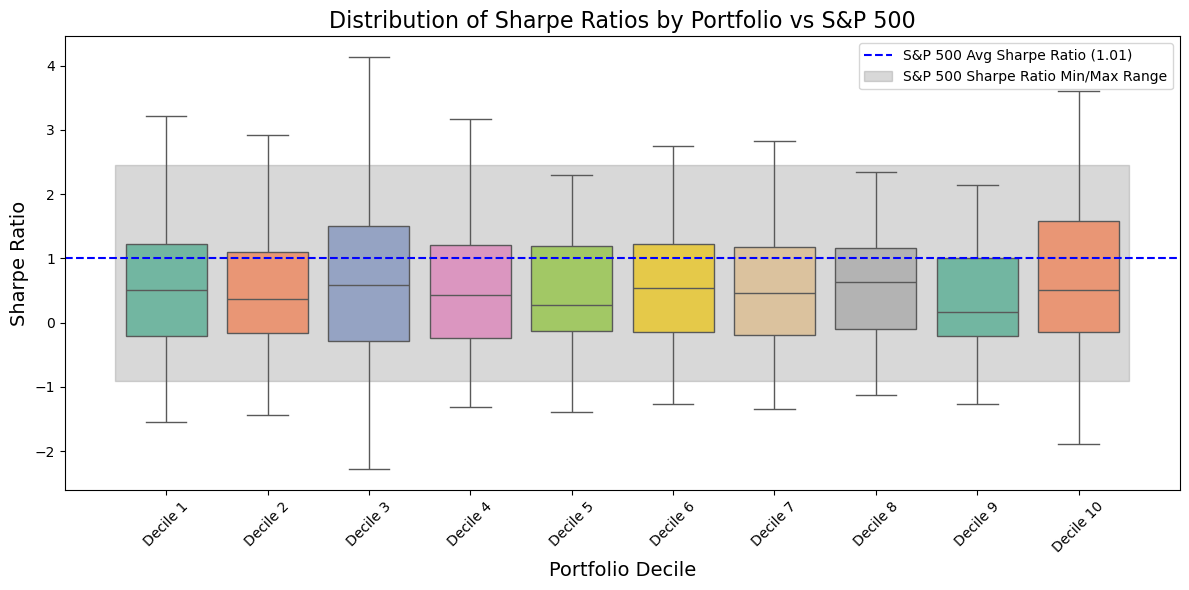

In [45]:
import matplotlib.pyplot as plt

# Merge the S&P 500 Sharpe ratio with the annual_grouped data to match years
merged_data = annual_grouped.reset_index().merge(sp500_index[['sharpe_ratio']], on='date', how='left', suffixes=('', '_sp500'))

# Create the boxplot for Sharpe ratio by portfolio
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='portfolio', y='sharpe_ratio', palette='Set2', showfliers=False)

# Add a line plot for the market's (sp500) average Sharpe ratio over the period.
avg_sharpe_sp500 = sp500_index['sharpe_ratio'].mean()
min_sharpe_sp500 = sp500_index['sharpe_ratio'].min()
max_sharpe_sp500 = sp500_index['sharpe_ratio'].max()
plt.axhline(avg_sharpe_sp500, color='blue', linestyle='--', label=f'S&P 500 Avg Sharpe Ratio ({avg_sharpe_sp500:.2f})')
# Add shaded area for the min/max Sharpe ratio
plt.fill_between(plt.gca().get_xlim(), min_sharpe_sp500, max_sharpe_sp500, color='gray', alpha=0.3, label=f'S&P 500 Sharpe Ratio Min/Max Range')

# Set the title and labels
plt.title('Distribution of Sharpe Ratios by Portfolio vs S&P 500', fontsize=16)
plt.xlabel('Portfolio Decile', fontsize=14)
plt.ylabel('Sharpe Ratio', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.legend()
plt.show()


**Comment on results**

On average, not a single of the portfolios were able to score higher than marked on the average Sharpe Ratio over the period. Thus, using twitter data to perform a sentiment analysis and trade on does not seem to yield positive returns in the long term.
 
Furthermore, there does not seem to be any trend in between the deciles. Therefore, based on this analysis, using twitter as a sentiment analysis to trade on does not seem to be a good factor to trade on.
 
It would be interesting to investigate wether there is a potential strategy by trading based on tweets in the short-term. Ex., if a firm have a significant change in number of tweets and the ratio of positive/negative tweets, we might see a positive short term return which we can trade on. We consider this to be outside the scope of this project, but deem it interesting as a potential extension in the investigation of predicting market movements using twitter as sentiment data.
